In [4]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import hist
import matplotlib.pyplot as plt

In [5]:
NanoAODSchema.warn_missing_crossrefs = False

fname = "data/02905d4b-dde0-480f-baec-116d4998d612.root"
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=NanoAODSchema,
).events()

In [6]:
events["HT"] = ak.sum(abs(events.GenJet.pt), axis=1)
events["alpha"] = ak.fill_none(ak.pad_none(events.GenJet,3)[:, 2].pt / events.HT,0)
cut_events = events[ak.num(events.GenJet) > 1]

In [8]:
alph = (
    hist.Hist.new.Reg(60, 0, 1, name="alpha", label="j3/HT ratio")
    .Weight()
)

In [9]:
alph.fill(events.alpha)

Hist(Regular(60, 0, 1, name='alpha', label='j3/HT ratio'), storage=Weight()) # Sum: WeightedSum(value=505920, variance=505920)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fabbf5bb220>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

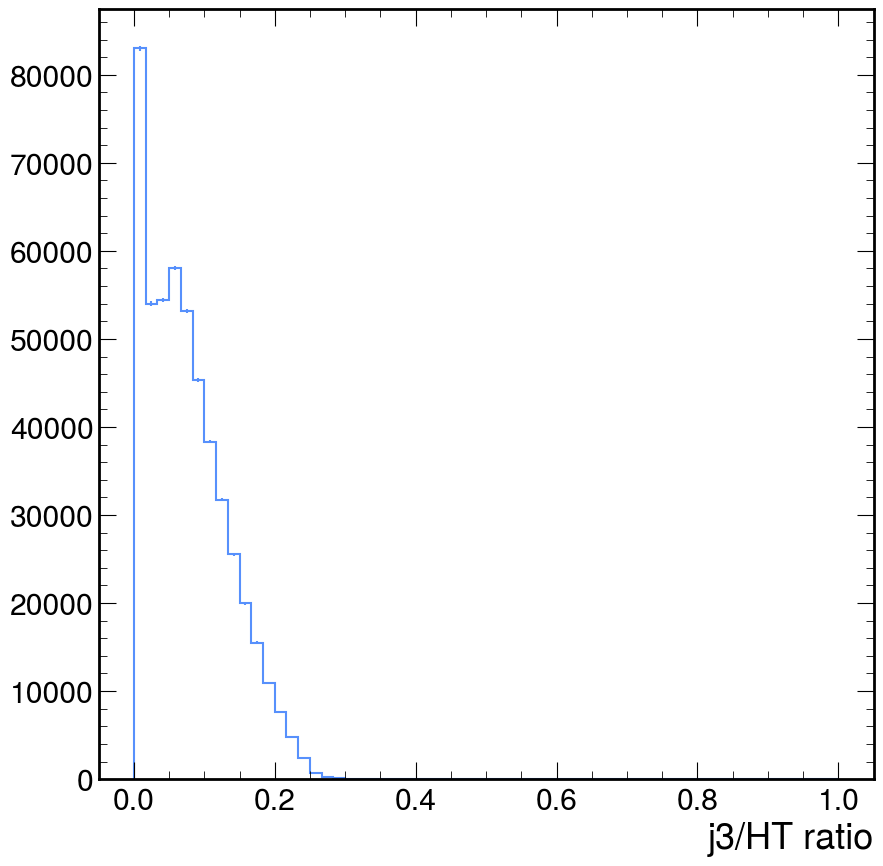

In [10]:
alph.plot1d()

In [15]:
h = (
    hist.Hist.new.Reg(60, 0, 1000, name="mis-align", label="GenJet1.pt - GenJet2.pt [GeV]")
    .Weight()
)

In [16]:
h.fill(
    abs(cut_events.GenJet[:, 0].pt - cut_events.GenJet[:, 1].pt))

Hist(Regular(60, 0, 1000, name='mis-align', label='GenJet1.pt - GenJet2.pt [GeV]'), storage=Weight()) # Sum: WeightedSum(value=500051, variance=500051) (WeightedSum(value=505916, variance=505916) with flow)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fab83c8a310>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

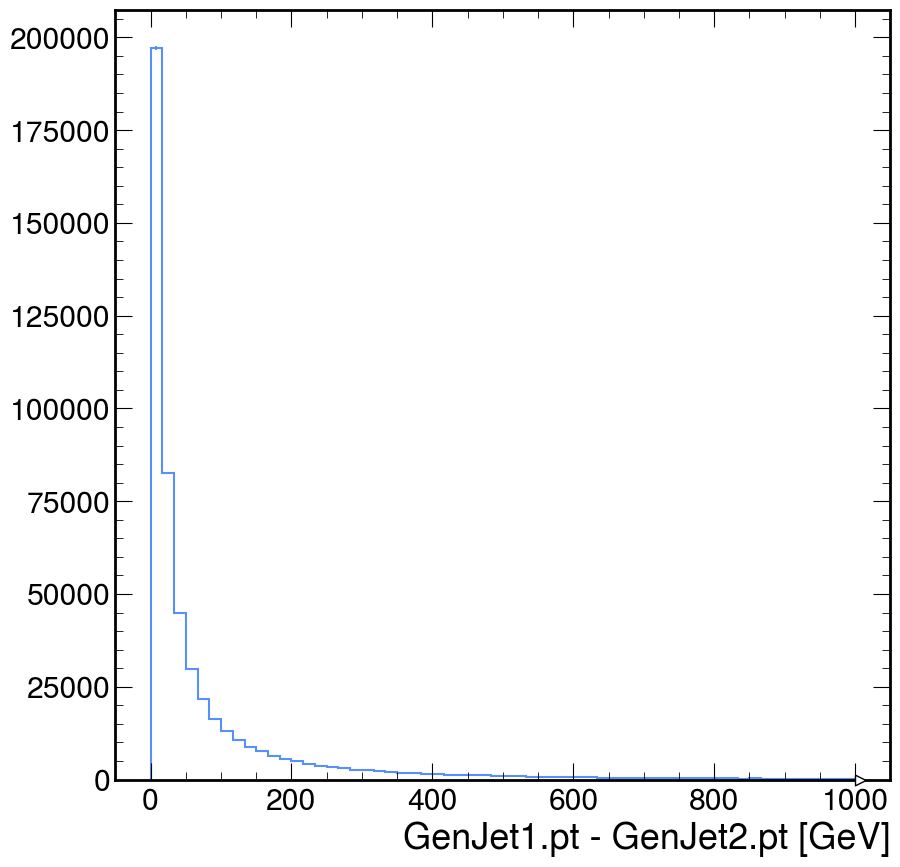

In [17]:
h.plot1d()

In [56]:
h2 = (
    hist.Hist.new
    .Reg(40, 0, 125, name="mis-align", label="GenJet1.pt - GenJet2.pt [GeV]")
    .Reg(6, 0, 0.3, name="alpha", label="j3/HT ratio")
    .Weight()
)

In [57]:
h2.fill(
    abs(cut_events.GenJet[:, 0].pt - cut_events.GenJet[:, 1].pt),
    cut_events.alpha
)

Hist(
  Regular(40, 0, 125, name='mis-align', label='GenJet1.pt - GenJet2.pt [GeV]'),
  Regular(6, 0, 0.3, name='alpha', label='j3/HT ratio'),
  storage=Weight()) # Sum: WeightedSum(value=411190, variance=411190) (WeightedSum(value=505916, variance=505916) with flow)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fab774ed790>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fab77491d60>, text=[])

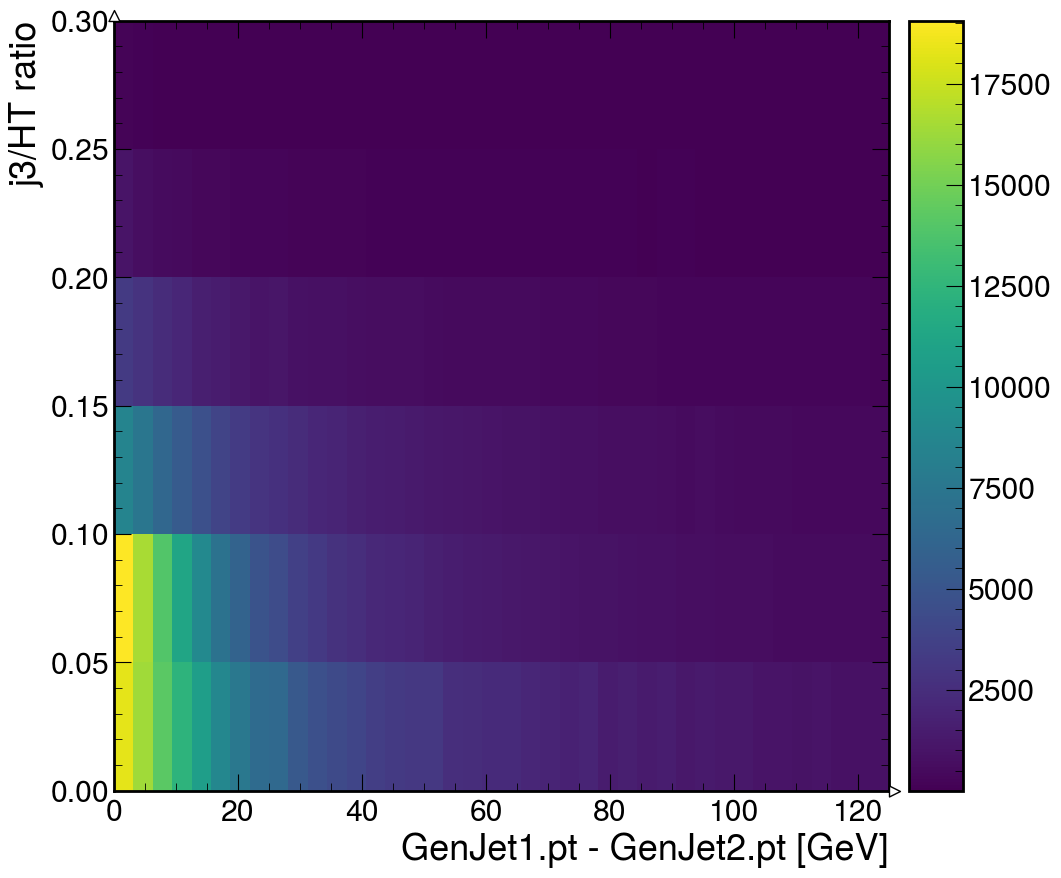

In [58]:
h2.plot2d()

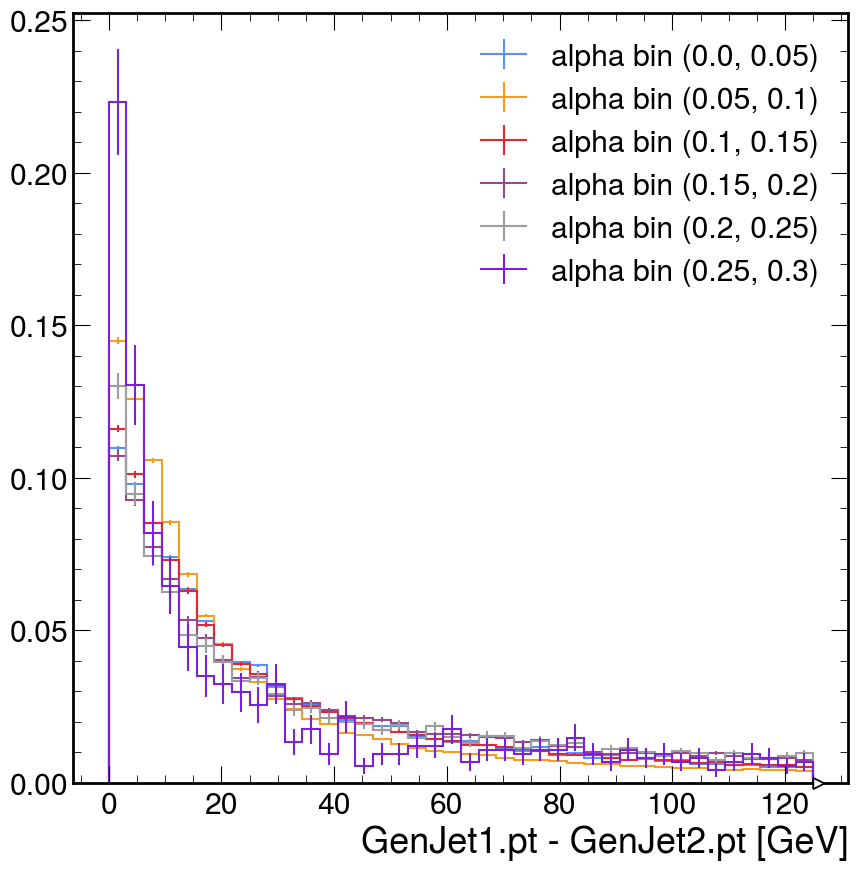

In [62]:
hf = []

for i in range(len(h2.axes[1])):
    low, high = h2.axes[1][i]
    norm = (1/h2[:,i].sum().value)
    hf.append((norm * h2[:,i]))
    (norm * h2[:,i]).plot1d(label=f"alpha bin {round(low,2),round(high,2)}")

plt.legend()

In [60]:
import matplotlib.colors as mcolors

In [ ]:
np.array(h2.view().T)

TypeError: array() got an unexpected keyword argument 'type'

Text(0, 1, '$\\alpha$')

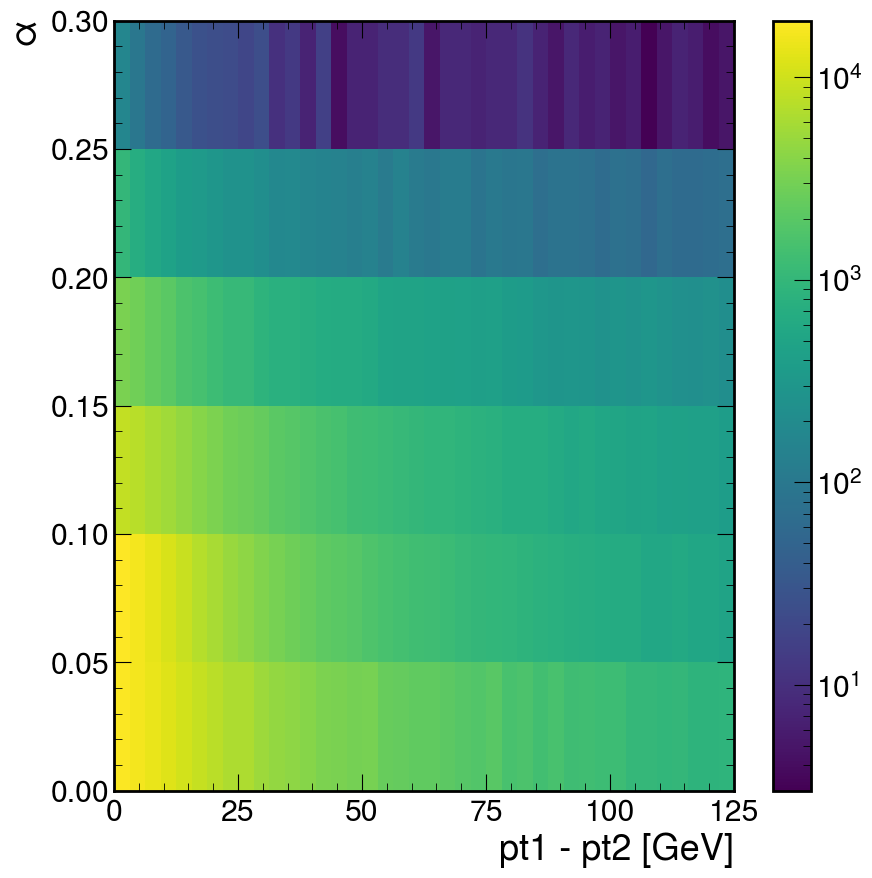

In [73]:
fig, ax = plt.subplots()
mesh = ax.pcolormesh(
    h2.axes[0].edges,
    h2.axes[1].edges,
    h2.view().value.T,  # transpose for correct orientation
    norm=mcolors.LogNorm(),  # Apply log scale
    cmap="viridis"
)
cbar = fig.colorbar(mesh, ax=ax)

ax.set_xlabel("pt1 - pt2 [GeV]")
ax.set_ylabel(r"$\alpha$")

In [74]:
import mplhep as hep
hep.style.use("CMS")

In [75]:
import iminuit.cost
import numpy as np

In [76]:
def f(x, background, mu, gamma):
    return (
        background
        + (1 - background) * gamma**2 / ((x - mu) ** 2 + gamma**2) / np.pi / gamma
    )
def gauss(x, a,b,c):
    return a*np.exp(-((x-b)**2/(2*c**2)))
def gauss_tail(x, a,b,c,e):
    return a*np.exp(-((x-b)**2/(2*c**2))) + e

In [105]:
fit1 = hf[0].project("mis-align")
loss1 = iminuit.cost.LeastSquares(
    fit1.axes[0].centers, fit1.values(), np.sqrt(fit1.variances()), gauss
)
loss1.mask = fit1.variances() > 0
minimizer = iminuit.Minuit(loss1,a=0.1,b=0,c=1)
minimizer.migrad()
minimizer.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7461 (χ²/ndof = 201.7)     │              Nfcn = 572              │
│ EDM = 32.8 (Goal: 0.0002)        │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   15.4    │    0.6    │            │            │         │         │       │
│ 1 │ b    │   -387    │     4     │            │            │         │         │       │
│ 2 │ c    │   120.3   │    0.8    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │     a     b     c │
├───┼───────────────────┤
│ a │ 0.306 -1.79  0.32 │
│ b │ -1.79  14.4  -3.0 │
│ c │  0.32  -3.0  0.65 │
└───┴───────────────────┘

In [ ]:
fits = []
loss = []
mins = []
for i in range(len(hf)):
    fit1 = hf[i].project("mis-align")
    loss1 = iminuit.cost.LeastSquares(
        fit1.axes[0].centers, fit1.values(), np.sqrt(fit1.variances()), gauss
    )
    loss1.mask = fit1.variances() > 0
    minimizer = iminuit.Minuit(loss1,a=0.1,b=0,c=1)
    minimizer.migrad()
    minimizer.hesse()
    fits.append(fit1)
    loss.append(loss1)
    mins.append(minimizer)

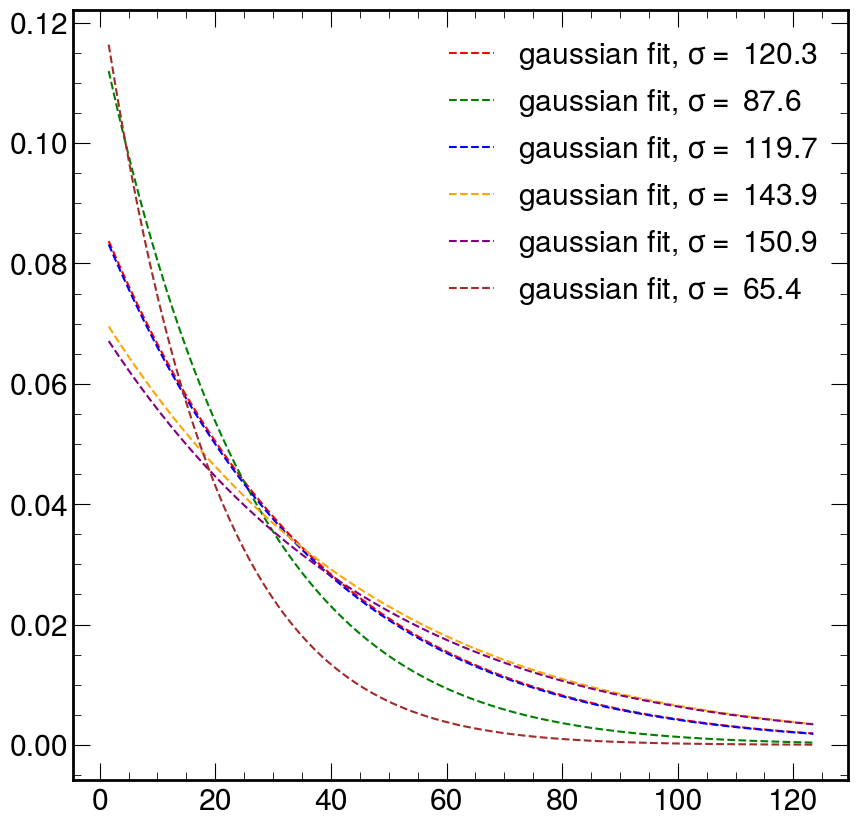

In [107]:
cols = ["red", "green", "blue", "orange", "purple", "brown"]

for i in range(len(fits)):
    x1 = np.linspace(min(loss[i].x), max(loss[i].x), 200)

    plt.plot(x1, gauss(x1, *mins[i].values),linestyle="dashed",color=cols[i],
            label=r"gaussian fit, $\sigma =$ " + str(round(mins[i].values["c"],1)))
    
plt.legend()